In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Concatenate, BatchNormalization, Multiply, Add
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

import numpy as np
import os
import json
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# Define the concepts as in bottleneck.py
CONCEPTS = [
    'midline_shift', 'edema', 'ventricular_compression', 'ring_enhancement', 'mass', 'nodule', 'abnormal_signal'

]

In [ ]:
def create_bottleneck_model(input_shape=(240, 240, 3)):
    """
    Creates a VGG16 model with bottleneck features for concept prediction
    """
    # Load pre-trained VGG16 model without top layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model

    # Add custom layers for concept prediction
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Output layer with sigmoid activation for multi-label concept prediction
    predictions = Dense(len(CONCEPTS), activation='sigmoid', name='concepts')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model


In [ ]:
def calculate_concept_weights(y_train):
    """
    Calculate weights for each concept based on class imbalance
    """
    total_samples = len(y_train)
    concept_pos_counts = np.sum(y_train, axis=0)

    # Calculate raw weights based on class imbalance
    raw_weights = []
    print("\nConcept class weights (before normalization):")

    for i, concept in enumerate(CONCEPTS):
        pos_count = max(concept_pos_counts[i], 1)  # Avoid zero division
        neg_count = total_samples - pos_count

        # Raw weight: ratio of negatives to positives
        weight = neg_count / pos_count
        raw_weights.append(weight)

        pos_ratio = (pos_count / total_samples) * 100
        print(f"{concept:<25}: raw weight = {weight:.2f} (positive samples: {pos_ratio:.1f}%)")

    # Normalize weights so the mean weight is 1
    mean_weight = np.mean(raw_weights)
    normalized_weights = np.array(raw_weights) / mean_weight

    print("\nNormalized concept class weights:")
    for concept, norm_weight in zip(CONCEPTS, normalized_weights):
        print(f"{concept:<25}: normalized weight = {norm_weight:.2f}")

    return normalized_weights

In [ ]:
def weighted_binary_crossentropy(concept_weights):
    """
    Create a weighted binary crossentropy loss function that properly handles batch dimensions
    """
    def loss(y_true, y_pred):
        # Ensure inputs are float32
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        # Calculate binary crossentropy
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        bce = -(y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))

        # Reshape weights to [1, num_concepts] for broadcasting
        weights_tensor = tf.constant(concept_weights, dtype=tf.float32)
        weights_tensor = tf.reshape(weights_tensor, [1, -1])

        # Apply weights and calculate mean
        weighted_loss = bce * weights_tensor
        return tf.reduce_mean(weighted_loss)

    return loss

In [ ]:
def train_bottleneck_model(model, X_train, y_train, X_val, y_val, batch_size=16, epochs=75):
    """
    Train the bottleneck model with concept predictions
    """
    # Compile model with binary crossentropy for multi-label classification

    concept_weights = calculate_concept_weights(y_train)

    def multi_label_accuracy(y_true, y_pred):
        threshold = 0.5
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred > threshold, tf.float32)
        return tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred), tf.float32))

    def weighted_binary_crossentropy(y_true, y_pred):
        weights_tensor = tf.constant(concept_weights, dtype=tf.float32)
        weights_tensor = tf.reshape(weights_tensor, (1, len(CONCEPTS)))
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        weighted_bce = bce * weights_tensor
        return tf.reduce_mean(weighted_bce)

    data_gen = ImageDataGenerator(
        rotation_range=5,  # Random rotation in the range (-10, 10) degrees
        width_shift_range=0.2,  # Random horizontal shift
        height_shift_range=0.2,  # Random vertical shift
        zoom_range=0.1,  # Random zoom
        horizontal_flip=True,  # Random horizontal flip
        fill_mode='nearest'  # Strategy for filling new pixels
    )

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=10,
        min_lr=1e-6
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping, lr_scheduler]
    )

    return history


In [ ]:
def evaluate_concepts(model, X_test, y_test):
    """
    Evaluate the model's performance on each concept
    """
    # Get predictions
    y_pred = model.predict(X_test)

    # Convert predictions to binary (0 or 1) using 0.5 threshold
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Print performance for each concept
    print("\nPer-concept performance:")
    print("-" * 50)

    for i, concept in enumerate(CONCEPTS):
        report = classification_report(
            y_test[:, i],
            y_pred_binary[:, i],
            target_names=['Negative', 'Positive'],
            zero_division=0
        )
        print(f"\nConcept: {concept}")
        print(report)

    # Calculate overall accuracy
    overall_accuracy = np.mean(y_pred_binary == y_test)
    print(f"\nOverall Accuracy: {overall_accuracy:.4f}")

    return y_pred, y_pred_binary


In [ ]:
def create_train_test_split(case_ids, test_size=0.15, random_state=42):
    """
    Creates a consistent train/test split based on case IDs
    """
    train_ids, test_ids = train_test_split(
        list(case_ids),
        test_size=test_size,
        random_state=random_state
    )

    # Create mappings for easy lookup
    split_mapping = {
        case_id: 'test' if case_id in test_ids else 'train'
        for case_id in case_ids
    }

    return split_mapping



In [ ]:
def load_data_from_directory(directory, concepts_json_path, split_mapping):
    """
    Modified to use consistent train/test split
    """
    X_train_data = []
    y_train_concepts = []
    X_test_data = []
    y_test_concepts = []

    # Load concepts data from JSON
    with open(concepts_json_path, 'r') as f:
        concepts_data = json.load(f)

    for file_name in os.listdir(directory):
        if file_name.endswith('.npz'):
            case_id = file_name.split('_')[0]  # Assuming format "case_id_..."

            # Skip if case_id not in split_mapping
            if case_id not in split_mapping:
                continue

            file_path = os.path.join(directory, file_name)
            data = np.load(file_path, allow_pickle=True)
            image = data['image']

            # Get concept values
            concept_values = []
            for concept in CONCEPTS:
                value = float(concepts_data.get(case_id, {}).get(concept, 0))
                concept_values.append(value)

            # Add to appropriate split
            if split_mapping[case_id] == 'test':
                X_test_data.append(image)
                y_test_concepts.append(concept_values)
            else:
                X_train_data.append(image)
                y_train_concepts.append(concept_values)

    # Convert to numpy arrays
    X_train = np.array(X_train_data)
    y_train = np.array(y_train_concepts)
    X_test = np.array(X_test_data)
    y_test = np.array(y_test_concepts)

    return X_train, y_train, X_test, y_test


In [ ]:

def load_and_preprocess_data(data_dir, concepts_json_paths, split_mapping):
    """
    Modified to use consistent train/test split
    """
    X_train_list = []
    y_train_list = []
    X_test_list = []
    y_test_list = []

    for cancer_type, directory in data_dir.items():
        X_train, y_train, X_test, y_test = load_data_from_directory(
            directory,
            concepts_json_paths[cancer_type],
            split_mapping
        )

        X_train_list.append(X_train)
        y_train_list.append(y_train)
        X_test_list.append(X_test)
        y_test_list.append(y_test)

    # Combine data from all cancer types
    X_train = np.concatenate(X_train_list)
    y_train = np.concatenate(y_train_list)
    X_test = np.concatenate(X_test_list)
    y_test = np.concatenate(y_test_list)

    # Create validation split from training data
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.15, random_state=42
    )

    return X_train, y_train, X_val, y_val, X_test, y_test


In [ ]:
# Define data directories and concept JSON paths
# data_dir = {
#     'GLI': '/content/drive/MyDrive/all-npzs/processed_data_GLI',
#     'MET': '/content/drive/MyDrive/all-npzs/processed_data_MET',
#     'MEN': '/content/drive/MyDrive/all-npzs/processed_data_MEN'
# }

data_dir_axial = {
    'GLI': '/content/drive/MyDrive/npzs-all-planes/Axial/GLI_axial',
    'MET': '/content/drive/MyDrive/npzs-all-planes/Axial/MET_axial',
    'MEN': '/content/drive/MyDrive/npzs-all-planes/Axial/MEN_axial'
}

data_dir_coronal = {
    'GLI': '/content/drive/MyDrive/npzs-all-planes/Coronal/GLI_coronal',
    'MET': '/content/drive/MyDrive/npzs-all-planes/Coronal/MET_coronal',
    'MEN': '/content/drive/MyDrive/npzs-all-planes/Coronal/MEN_coronal'
}

data_dir_sagittal = {
    'GLI': '/content/drive/MyDrive/npzs-all-planes/Sagittal/GLI_sagittal',
    'MET': '/content/drive/MyDrive/npzs-all-planes/Sagittal/MET_sagittal',
    'MEN': '/content/drive/MyDrive/npzs-all-planes/Sagittal/MEN_sagittal'
}


concepts_json_paths = {
    'GLI': '/content/drive/MyDrive/Dataset/GLI_concepts.json',
    'MET': '/content/drive/MyDrive/Dataset/MET_concepts.json',
    'MEN': '/content/drive/MyDrive/Dataset/MEN_concepts.json'
}


all_case_ids = set()
for cancer_type, json_path in concepts_json_paths.items():
    with open(json_path, 'r') as f:
        all_case_ids.update(json.load(f).keys())
# split_mapping = create_train_test_split(all_case_ids)

file_path = "/content/drive/MyDrive/split_mapping.json"

# Load the dictionary from the JSON file
with open(file_path, "r") as json_file:
    split_mapping = json.load(json_file)


In [ ]:
# def self_training_loop(model, X_train, y_train, X_val, y_val, X_test, y_test, unlabeled_data_dirs,
#                       percentile_threshold=25, batch_size=16, epochs=50):
#     """
#     Implement self-training using entropy as confidence measure
#     Selects samples based on entropy percentile instead of absolute threshold
#     """
#     print("Initial training with labeled data...")
#     history = train_bottleneck_model(model, X_train, y_train, X_val, y_val,
#                                    batch_size=batch_size, epochs=75)

#     model.save('vgg16_bottleneck_model_axial.keras')

#     # Evaluate model before self-training
#     print("\nModel performance BEFORE self-training:")
#     print("-" * 50)
#     y_pred_before, y_pred_binary_before = evaluate_concepts(model, X_test, y_test)

#     # Load unlabeled data
#     unlabeled_X = []
#     for directory in unlabeled_data_dirs:
#         X_unlabeled, _ = load_unlabeled_data(directory)
#         if X_unlabeled is not None:
#             unlabeled_X.append(X_unlabeled)

#     if unlabeled_X:
#         X_unlabeled_all = np.concatenate(unlabeled_X, axis=0)

#         # Get predictions for unlabeled data
#         pseudo_labels = model.predict(X_unlabeled_all)

#         # Calculate entropy for each prediction
#         entropy = -np.sum(
#             pseudo_labels * np.log(pseudo_labels + 1e-10) +
#             (1 - pseudo_labels) * np.log(1 - pseudo_labels + 1e-10),
#             axis=1
#         )

#         # Calculate entropy threshold based on percentile
#         entropy_threshold = np.percentile(entropy, percentile_threshold)

#         print("\nEntropy statistics:")
#         print(f"Mean entropy: {np.mean(entropy):.3f}")
#         print(f"Min entropy: {np.min(entropy):.3f}")
#         print(f"Max entropy: {np.max(entropy):.3f}")
#         print(f"Selected threshold ({percentile_threshold}th percentile): {entropy_threshold:.3f}")

#         # Plot entropy distribution
#         # plt.figure(figsize=(10, 5))
#         # plt.hist(entropy, bins=50)
#         # plt.axvline(x=entropy_threshold, color='r', linestyle='--',
#         #            label=f'{percentile_threshold}th percentile ({entropy_threshold:.3f})')
#         # plt.title('Distribution of Prediction Entropy')
#         # plt.xlabel('Entropy (lower = more confident)')
#         # plt.ylabel('Number of Predictions')
#         # plt.legend()
#         # plt.show()

#         # Select confident predictions (low entropy)
#         confident_mask = entropy < entropy_threshold
#         X_confident = X_unlabeled_all[confident_mask]
#         y_confident = pseudo_labels[confident_mask]

#         print(f"\nTotal unlabeled samples: {len(entropy)}")
#         print(f"Confident samples selected: {np.sum(confident_mask)}")
#         print(f"Percentage selected: {(np.sum(confident_mask)/len(entropy))*100:.1f}%")

#         if len(X_confident) > 0:
#             # Combine original and pseudo-labeled data
#             X_combined = np.concatenate([X_train, X_confident])
#             y_combined = np.concatenate([y_train, y_confident])

#             # Final training with combined data
#             print("\nTraining with combined labeled and pseudo-labeled data...")
#             history = train_bottleneck_model(
#                 model, X_combined, y_combined, X_val, y_val,
#                 batch_size=batch_size, epochs=epochs
#             )

#             # Evaluate final performance
#             print("\nModel performance AFTER self-training:")
#             print("-" * 50)
#             y_pred_after, y_pred_binary_after = evaluate_concepts(model, X_test, y_test)
#         else:
#             print("\nNo confident predictions found. Skipping self-training step.")

#     return model, history

# # Update the call to self_training_loop
# axial_model, history = self_training_loop(
#     axial_model,
#     X_train_a, y_train_a,
#     X_val_a, y_val_a,
#     X_test_a, y_test_a,
#     unlabeled_data_dirs,
#     percentile_threshold=10  # Select the 25% most confident predictions
# )

In [ ]:
# Print dataset sizes
print("\nDataset Sizes:")
print(f"Training set: {len(X_train_a)} samples")
print(f"Validation set: {len(X_val_a)} samples")
print(f"Test set: {len(X_test_a)} samples")


Dataset Sizes:
Training set: 503 samples
Validation set: 89 samples
Test set: 105 samples


In [ ]:
# Create the model
axial_model = create_bottleneck_model()

# Load and preprocess data
X_train_a, y_train_a, X_val_a, y_val_a, X_test_a, y_test_a = load_and_preprocess_data(
    data_dir_axial, concepts_json_paths, split_mapping
)

file_path = "/content/drive/MyDrive/split_mapping.json"

# Save dictionary as a JSON file
with open(file_path, "w") as json_file:
    json.dump(split_mapping, json_file, indent=4)

print(f"Dictionary saved as JSON at {file_path}")


# Train the model
history = train_bottleneck_model(axial_model, X_train_a, y_train_a, X_val_a, y_val_a)

# Evaluate the model
y_pred_a, y_pred_binary_a = evaluate_concepts(axial_model, X_test_a, y_test_a)

# Save the model
axial_model.save('/content/drive/MyDrive/models/vgg16_bottleneck_model_axial_7.keras')




Dictionary saved as JSON at /content/drive/MyDrive/split_mapping.json

Concept class weights (before normalization):
midline_shift            : raw weight = 2.67 (positive samples: 27.2%)
edema                    : raw weight = 0.65 (positive samples: 60.4%)
ventricular_compression  : raw weight = 2.03 (positive samples: 33.0%)
ring_enhancement         : raw weight = 1.38 (positive samples: 41.9%)
mass                     : raw weight = 1.94 (positive samples: 34.0%)
nodule                   : raw weight = 3.09 (positive samples: 24.5%)
abnormal_signal          : raw weight = 0.20 (positive samples: 83.1%)

Normalized concept class weights:
midline_shift            : normalized weight = 1.56
edema                    : normalized weight = 0.38
ventricular_compression  : normalized weight = 1.19
ring_enhancement         : normalized weight = 0.81
mass                     : normalized weight = 1.13
nodule                   : normalized weight = 1.81
abnormal_signal          : normalized w

In [ ]:
# Create the model
coronal_model = create_bottleneck_model(input_shape=(240, 155, 3))

# Load and preprocess data
X_train_c, y_train_c, X_val_c, y_val_c, X_test_c, y_test_c = load_and_preprocess_data(
    data_dir_coronal, concepts_json_paths, split_mapping
)

# Train the model
history = train_bottleneck_model(coronal_model, X_train_c, y_train_c, X_val_c, y_val_c)

# Evaluate the model
y_pred_c, y_pred_binary_c = evaluate_concepts(coronal_model, X_test_c, y_test_c)

# Save the model
coronal_model.save('/content/drive/MyDrive/models/vgg16_bottleneck_model_coronal_7.keras')


Concept class weights (before normalization):
midline_shift            : raw weight = 2.64 (positive samples: 27.4%)
edema                    : raw weight = 0.63 (positive samples: 61.2%)
ventricular_compression  : raw weight = 1.91 (positive samples: 34.4%)
ring_enhancement         : raw weight = 1.28 (positive samples: 43.9%)
mass                     : raw weight = 2.10 (positive samples: 32.2%)
nodule                   : raw weight = 2.93 (positive samples: 25.4%)
abnormal_signal          : raw weight = 0.19 (positive samples: 83.9%)

Normalized concept class weights:
midline_shift            : normalized weight = 1.58
edema                    : normalized weight = 0.38
ventricular_compression  : normalized weight = 1.14
ring_enhancement         : normalized weight = 0.76
mass                     : normalized weight = 1.26
nodule                   : normalized weight = 1.75
abnormal_signal          : normalized weight = 0.11
Epoch 1/75
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - acc

In [ ]:
# Create the model
sagittal_model = create_bottleneck_model(input_shape=(240, 155, 3))

# Load and preprocess data
X_train_s, y_train_s, X_val_s, y_val_s, X_test_s, y_test_s = load_and_preprocess_data(
    data_dir_sagittal, concepts_json_paths, split_mapping
)

# Train the model
history = train_bottleneck_model(sagittal_model, X_train_s, y_train_s, X_val_s, y_val_s)

# Evaluate the model
y_pred_s, y_pred_binary_s = evaluate_concepts(sagittal_model, X_test_s, y_test_s)

# Save the model
sagittal_model.save('/content/drive/MyDrive/models/vgg16_bottleneck_model_sagittal_7.keras')


Concept class weights (before normalization):
midline_shift            : raw weight = 2.84 (positive samples: 26.0%)
edema                    : raw weight = 0.66 (positive samples: 60.2%)
ventricular_compression  : raw weight = 1.98 (positive samples: 33.6%)
ring_enhancement         : raw weight = 1.33 (positive samples: 42.9%)
mass                     : raw weight = 2.12 (positive samples: 32.0%)
nodule                   : raw weight = 2.78 (positive samples: 26.4%)
abnormal_signal          : raw weight = 0.21 (positive samples: 82.3%)

Normalized concept class weights:
midline_shift            : normalized weight = 1.67
edema                    : normalized weight = 0.39
ventricular_compression  : normalized weight = 1.16
ring_enhancement         : normalized weight = 0.78
mass                     : normalized weight = 1.25
nodule                   : normalized weight = 1.63
abnormal_signal          : normalized weight = 0.13
Epoch 1/75
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - acc

In [ ]:
# def create_ensemble_model(input_shape=(None,), num_concepts=None):
#     """
#     Creates a simple neural network to combine predictions from multiple modalities
#     """
#     inputs = tf.keras.Input(shape=input_shape)
#     x = Dense(128, activation='relu')(inputs)
#     x = Dropout(0.3)(x)
#     x = Dense(64, activation='relu')(x)
#     x = Dropout(0.2)(x)
#     outputs = Dense(num_concepts, activation='sigmoid')(x)

#     model = Model(inputs=inputs, outputs=outputs)
#     return model


In [ ]:
# save_path = f'/content/drive/MyDrive/models/vgg16_bottleneck_model_sagittal.keras'
# os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Create directory if it doesn't exist
# sagittal_model.save(save_path)
# print(f"Model saved to: {save_path}")

In [ ]:
def create_ensemble_model(num_concepts=len(CONCEPTS)):
    """
    Creates an ensemble model with a different architecture
    """
    # Input layers for predictions from each view
    axial_input = Input(shape=(num_concepts,), name='axial_input')
    coronal_input = Input(shape=(num_concepts,), name='coronal_input')
    sagittal_input = Input(shape=(num_concepts,), name='sagittal_input')

    # Give each view its own weight multiplier (learnable parameter)
    axial_weight = Dense(num_concepts, activation='sigmoid')(axial_input)
    coronal_weight = Dense(num_concepts, activation='sigmoid')(coronal_input)
    sagittal_weight = Dense(num_concepts, activation='sigmoid')(sagittal_input)

    # Weight the predictions
    weighted_axial = Multiply()([axial_input, axial_weight])
    weighted_coronal = Multiply()([coronal_input, coronal_weight])
    weighted_sagittal = Multiply()([sagittal_input, sagittal_weight])

    # Combine weighted predictions
    merged = Add()([weighted_axial, weighted_coronal, weighted_sagittal])

    # Normalize the combined predictions
    outputs = Dense(num_concepts, activation='sigmoid')(merged)

    ensemble_model = Model(
        inputs=[axial_input, coronal_input, sagittal_input],
        outputs=outputs
    )

    # Use a custom learning rate
    optimizer = Adam(learning_rate=0.01)

    ensemble_model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return ensemble_model

def train_ensemble_model(axial_model, coronal_model, sagittal_model,
                        X_train_a, X_train_c, X_train_s, y_train,
                        X_val_a, X_val_c, X_val_s, y_val,
                        batch_size=16, epochs=100):
    """
    Train the ensemble model using predictions from individual models
    """
    # Get predictions from each model
    train_axial_preds = axial_model.predict(X_train_a)
    train_coronal_preds = coronal_model.predict(X_train_c)
    train_sagittal_preds = sagittal_model.predict(X_train_s)

    print(f"Axial predictions shape: {train_axial_preds.shape}")
    print(f"Coronal predictions shape: {train_coronal_preds.shape}")
    print(f"Sagittal predictions shape: {train_sagittal_preds.shape}")
    print(f"Target shape: {y_train.shape}")

    val_axial_preds = axial_model.predict(X_val_a)
    val_coronal_preds = coronal_model.predict(X_val_c)
    val_sagittal_preds = sagittal_model.predict(X_val_s)

    train_inputs = [
        train_axial_preds,
        train_coronal_preds,
        train_sagittal_preds
    ]

    val_inputs = [
        val_axial_preds,
        val_coronal_preds,
        val_sagittal_preds
    ]

    ensemble_model = create_ensemble_model()



    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    history = ensemble_model.fit(
        train_inputs, y_train,  # Use actual training labels
        validation_data=(val_inputs, y_val),  # Use actual validation labels
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping]
    )

    return ensemble_model, history


In [ ]:


sagittal_model = tf.keras.models.load_model('/content/drive/MyDrive/models/vgg16_bottleneck_model_sagittal_7.keras')
coronal_model = tf.keras.models.load_model('/content/drive/MyDrive/models/vgg16_bottleneck_model_coronal_7.keras')
axial_model = tf.keras.models.load_model('/content/drive/MyDrive/models/vgg16_bottleneck_model_axial_7.keras')
ensemble_model = tf.keras.models.load_model('/content/drive/MyDrive/models/vgg16_ensemble_model.keras')




In [ ]:

X_train_a, y_train_a, X_val_a, y_val_a, X_test_a, y_test_a = load_and_preprocess_data(
    data_dir_axial, concepts_json_paths
)

X_train_c, y_train_c, X_val_c, y_val_c, X_test_c, y_test_c = load_and_preprocess_data(
    data_dir_coronal, concepts_json_paths
)

X_train_s, y_train_s, X_val_s, y_val_s, X_test_s, y_test_s = load_and_preprocess_data(
    data_dir_sagittal, concepts_json_paths
)






TypeError: Could not locate function 'weighted_binary_crossentropy'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'builtins', 'class_name': 'function', 'config': 'weighted_binary_crossentropy', 'registered_name': 'function'}

In [ ]:


# Train and evaluate the ensemble model
ensemble_model, ensemble_history = train_ensemble_model(
    axial_model, coronal_model, sagittal_model,
    X_train_a, X_train_c, X_train_s, y_train_a,  # Use training data
    X_val_a, X_val_c, X_val_s, y_val_a  # Use validation data
)

# Get ensemble predictions
ensemble_preds = ensemble_model.predict([
    axial_model.predict(X_test_a),
    coronal_model.predict(X_test_c),
    sagittal_model.predict(X_test_s)
])

# Evaluate ensemble model
print("\nEnsemble Model Performance:")
print("-" * 50)
evaluate_concepts(ensemble_model,
                 [axial_model.predict(X_test_a),
                  coronal_model.predict(X_test_c),
                  sagittal_model.predict(X_test_s)],
                 y_test_a)

# Save the ensemble model
ensemble_model.save('/content/drive/MyDrive/models/vgg16_ensemble_model.keras')

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Axial predictions shape: (503, 7)
Coronal predictions shape: (503, 7)
Sagittal predictions shape: (503, 7)
Target shape: (503, 7)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.0734 - loss: 0.6658 - val_accuracy: 0.0337 - val_loss: 0.5823
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0525 - loss: 0.5753 - val_accuracy: 0.0337 - val_loss: 0.5487
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0678 - loss: 0.5476 - val_accuracy: 0.0337 - val_loss: 0.5235
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0480 - loss: 0.5170 - val_accuracy: 0.0337 - val_loss: 0.5098
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0711 - loss: 0.5080 - val_accuracy: 0.0337 - val_loss: 0.4912


In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import json

def load_concept_data(concepts_json_paths, binary_classification=True):
    """
    Load and prepare concept data for classification
    Binary_classification: If True, only include GLI and MET classes (no MEN)
    """
    X = []  # Will hold concept features
    y = []  # Will hold labels (0: GLI, 1: MET, 2: MEN)

    # Load each JSON file and extract features
    for tumor_type, json_path in concepts_json_paths.items():
        # Skip MEN if binary classification is requested
        if binary_classification and tumor_type == 'MEN':
            continue

        with open(json_path, 'r') as f:
            data = json.load(f)

        # Convert each case's concepts to a feature vector
        for case_id, case_concepts in data.items():
            # Extract concept values in consistent order
            feature_vector = [float(case_concepts.get(concept, 0)) for concept in CONCEPTS]

            X.append(feature_vector)

            # Assign label based on tumor type
            if tumor_type == 'GLI':
                y.append(0)
            elif tumor_type == 'MET':
                y.append(1)
            else:  # MEN
                y.append(2)

    return np.array(X), np.array(y), CONCEPTS


def train_evaluate_svm(X, y):
    """
    Train and evaluate SVM model with cross-validation
    """
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Create and train SVM
    svm = SVC(kernel='rbf', C=1.0, random_state=42)
    svm.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = svm.predict(X_test_scaled)

    # Print results
    print("\nClassification Report:")
    # Use appropriate target names based on the classes present
    target_names = ['Glioma', 'Metastasis'] if np.max(y) == 1 else ['Glioma', 'Metastasis', 'Meningioma']
    print(classification_report(y_test, y_pred, target_names=target_names))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    return svm, scaler


# Load and prepare the data
X, y, feature_names = load_concept_data(concepts_json_paths)

print("Dataset summary:")
print(f"Total samples: {len(X)}")
print(f"Feature names: {feature_names}")
print(f"Class distribution: {np.bincount(y)}")

# Train and evaluate the model
svm_model, scaler = train_evaluate_svm(X, y)

# Example of making a prediction for a new case
def predict_tumor_type(svm_model, scaler, concept_values):
    """
    Make prediction for a new case based on its concept values
    """
    # Scale the input

    X_new_scaled = scaler.transform([concept_values])

    # Make prediction
    prediction = svm_model.predict(X_new_scaled)[0]

    # Convert numeric prediction to tumor type
    tumor_types = ['Glioma', 'Metastasis', 'Meningioma']
    return tumor_types[prediction]

# Example usage:
example_concepts = [1, 1, 0, 1, 0, 0, 0]  # Example concept values
predicted_type = predict_tumor_type(svm_model, scaler, example_concepts)
print(f"\nExample prediction for concepts {example_concepts}:")
print(f"Predicted tumor type: {predicted_type}")

Dataset summary:
Total samples: 467
Feature names: ['midline_shift', 'edema', 'ventricular_compression', 'ring_enhancement', 'mass', 'nodule', 'abnormal_signal']
Class distribution: [230 237]

Classification Report:
              precision    recall  f1-score   support

      Glioma       0.95      0.76      0.84        46
  Metastasis       0.81      0.96      0.88        48

    accuracy                           0.86        94
   macro avg       0.88      0.86      0.86        94
weighted avg       0.88      0.86      0.86        94


Confusion Matrix:
[[35 11]
 [ 2 46]]

Example prediction for concepts [1, 1, 0, 1, 0, 0, 0]:
Predicted tumor type: Glioma


In [ ]:


from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import json

def load_concept_data(concepts_json_paths):
    """
    Load and prepare concept data for MLP classification
    """
    # Function remains the same as before
    X = []
    y = []

    for tumor_type, json_path in concepts_json_paths.items():
        with open(json_path, 'r') as f:
            data = json.load(f)

        for case_id, case_concepts in data.items():
            feature_vector = [float(case_concepts.get(concept, 0)) for concept in CONCEPTS]
            X.append(feature_vector)

            if tumor_type == 'GLI':
                y.append(0)
            elif tumor_type == 'MET':
                y.append(1)
            else:  # MEN
                y.append(2)

    return np.array(X), np.array(y), CONCEPTS

def train_evaluate_mlp(X, y):
    """
    Train and evaluate MLP model with cross-validation
    """
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Create and train MLP
    mlp = MLPClassifier(
        hidden_layer_sizes=(64, 32),  # Two hidden layers with 64 and 32 neurons
        activation='relu',
        solver='adam',
        max_iter=1000,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1
    )

    mlp.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = mlp.predict(X_test_scaled)

    # Print results
    print("\nClassification Report:")
    # Use appropriate target names based on the classes present
    target_names = ['Glioma', 'Metastasis'] if np.max(y) == 1 else ['Glioma', 'Metastasis', 'Meningioma']
    print(classification_report(y_test, y_pred, target_names=target_names))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    return mlp, scaler


def predict_tumor_type(mlp_model, scaler, concept_values):
    """
    Make prediction for a new case based on its concept values
    """
    X_new_scaled = scaler.transform([concept_values])
    prediction = mlp_model.predict(X_new_scaled)[0]

    tumor_types = ['Glioma', 'Metastasis', 'Meningioma']
    return tumor_types[prediction]

# Load and prepare the data
X, y, feature_names = load_concept_data(concepts_json_paths)

print("Dataset summary:")
print(f"Total samples: {len(X)}")
print(f"Feature names: {feature_names}")
print(f"Class distribution: {np.bincount(y)}")

# Train and evaluate the model
mlp_model, scaler = train_evaluate_mlp(X, y)

# Example usage:
example_concepts = [1, 1, 0, 1, 0, 0, 1]  # Example concept values
predicted_type = predict_tumor_type(mlp_model, scaler, example_concepts)
print(f"\nExample prediction for concepts {example_concepts}:")
print(f"Predicted tumor type: {predicted_type}")

Dataset summary:
Total samples: 697
Feature names: ['midline_shift', 'edema', 'ventricular_compression', 'ring_enhancement', 'mass', 'nodule', 'abnormal_signal']
Class distribution: [230 237 230]

Classification Report:
              precision    recall  f1-score   support

      Glioma       0.87      0.74      0.80        46
  Metastasis       0.74      0.77      0.76        48
  Meningioma       0.69      0.76      0.72        46

    accuracy                           0.76       140
   macro avg       0.77      0.76      0.76       140
weighted avg       0.77      0.76      0.76       140


Confusion Matrix:
[[34  4  8]
 [ 3 37  8]
 [ 2  9 35]]

Example prediction for concepts [1, 1, 0, 1, 0, 0, 1]:
Predicted tumor type: Glioma


In [ ]:
def train_evaluate_tree(X, y, feature_names, test_size=0.2):
    """
    Train and evaluate Decision Tree model
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )

    dt = DecisionTreeClassifier(
        max_depth=5,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )

    dt.fit(X_train, y_train)

    # Print training accuracy
    train_pred = dt.predict(X_train)
    print("\nTraining Accuracy:", accuracy_score(y_train, train_pred))

    # Test predictions and evaluation
    y_pred = dt.predict(X_test)

    # Get unique classes and their names
    unique_classes = np.unique(y)
    class_names = ['Glioma', 'Metastasis', 'Meningioma']
    target_names = [class_names[i] for i in unique_classes]

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=target_names))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print(f"\nTest Accuracy: {accuracy_score(y_test, y_pred):.4f}")

    print("\nFeature Importances:")
    for feature, importance in zip(feature_names, dt.feature_importances_):
        print(f"{feature}: {importance:.4f}")

    plt.figure(figsize=(20, 10))
    plot_tree(dt, feature_names=feature_names,
             class_names=target_names,
             filled=True, rounded=True)
    plt.title("Decision Tree Visualization")
    plt.show()

    return dt


In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

def load_data_with_split(data_dirs, concepts_json_paths, split_mapping, split_type="train", binary_classification=False):
    """
    Load data from each view based on the split mapping
    binary_classification: If True, only include GLI and MET classes (no MEN)
    """
    # Initialize data structures for each tumor type
    tumor_data = {'GLI': [], 'MET': [], 'MEN': []}
    tumor_labels = {'GLI': 0, 'MET': 1, 'MEN': 2}

    # Process each tumor type
    for tumor_type in ['GLI', 'MET', 'MEN']:
        # Skip MEN if binary classification is requested
        if binary_classification and tumor_type == 'MEN':
            continue

        # Get directory for this tumor type
        axial_dir = data_dir_axial[tumor_type]
        coronal_dir = data_dir_coronal[tumor_type]
        sagittal_dir = data_dir_sagittal[tumor_type]

        # Get concept data for this tumor type
        with open(concepts_json_paths[tumor_type], 'r') as f:
            concept_data = json.load(f)

        # Process each case
        for case_id in concept_data.keys():
            # Skip if not in the requested split
            if case_id not in split_mapping or split_mapping[case_id] != split_type:
                continue

            # Try to load data for this case from each view
            case_data = {'axial': None, 'coronal': None, 'sagittal': None}

            # Check axial files
            for file_name in os.listdir(axial_dir):
                if file_name.startswith(case_id + '_') and file_name.endswith('.npz'):
                    file_path = os.path.join(axial_dir, file_name)
                    try:
                        data = np.load(file_path, allow_pickle=True)
                        case_data['axial'] = data['image']
                    except Exception as e:
                        print(f"Error loading {file_path}: {e}")

            # Check coronal files
            for file_name in os.listdir(coronal_dir):
                if file_name.startswith(case_id + '_') and file_name.endswith('.npz'):
                    file_path = os.path.join(coronal_dir, file_name)
                    try:
                        data = np.load(file_path, allow_pickle=True)
                        case_data['coronal'] = data['image']
                    except Exception as e:
                        print(f"Error loading {file_path}: {e}")

            # Check sagittal files
            for file_name in os.listdir(sagittal_dir):
                if file_name.startswith(case_id + '_') and file_name.endswith('.npz'):
                    file_path = os.path.join(sagittal_dir, file_name)
                    try:
                        data = np.load(file_path, allow_pickle=True)
                        case_data['sagittal'] = data['image']
                    except Exception as e:
                        print(f"Error loading {file_path}: {e}")

            # If we have data for all views, add to our dataset
            if case_data['axial'] is not None and case_data['coronal'] is not None and case_data['sagittal'] is not None:
                tumor_data[tumor_type].append({
                    'case_id': case_id,
                    'data': case_data,
                    'label': tumor_labels[tumor_type]
                })

    # Prepare final arrays
    X_axial = []
    X_coronal = []
    X_sagittal = []
    y_labels = []

    for tumor_type, cases in tumor_data.items():
        for case in cases:
            # Process axial data
            axial_img = case['data']['axial']
            if len(axial_img.shape) == 3:
                axial_img = np.expand_dims(axial_img, axis=0)
            X_axial.append(axial_img)

            # Process coronal data
            coronal_img = case['data']['coronal']
            if len(coronal_img.shape) == 3:
                coronal_img = np.expand_dims(coronal_img, axis=0)
            X_coronal.append(coronal_img)

            # Process sagittal data
            sagittal_img = case['data']['sagittal']
            if len(sagittal_img.shape) == 3:
                sagittal_img = np.expand_dims(sagittal_img, axis=0)
            X_sagittal.append(sagittal_img)

            # Add label
            y_labels.append(case['label'])

    # Concatenate data
    X_axial = np.concatenate(X_axial) if X_axial else np.array([])
    X_coronal = np.concatenate(X_coronal) if X_coronal else np.array([])
    X_sagittal = np.concatenate(X_sagittal) if X_sagittal else np.array([])
    y_labels = np.array(y_labels)

    return X_axial, X_coronal, X_sagittal, y_labels


# Load binary classification data
X_train_axial_binary, X_train_coronal_binary, X_train_sagittal_binary, y_train_binary = load_data_with_split(
    [data_dir_axial, data_dir_coronal, data_dir_sagittal],
    concepts_json_paths,
    split_mapping,
    "train",
    binary_classification=True  # This filters out MEN cases
)

X_test_axial_binary, X_test_coronal_binary, X_test_sagittal_binary, y_test_binary = load_data_with_split(
    [data_dir_axial, data_dir_coronal, data_dir_sagittal],
    concepts_json_paths,
    split_mapping,
    "test",
    binary_classification=True  # This filters out MEN cases
)

print("\nBinary classification data loaded:")
print(f"Training samples: {len(y_train_binary)}")
print(f"Test samples: {len(y_test_binary)}")

# Generate concept predictions for binary classification data
train_axial_concepts_binary = axial_model.predict(X_train_axial_binary)
train_coronal_concepts_binary = coronal_model.predict(X_train_coronal_binary)
train_sagittal_concepts_binary = sagittal_model.predict(X_train_sagittal_binary)

# Combine using ensemble model
train_ensemble_inputs_binary = [train_axial_concepts_binary, train_coronal_concepts_binary, train_sagittal_concepts_binary]
train_ensemble_concepts_binary = ensemble_model.predict(train_ensemble_inputs_binary)

# Same for test data
test_axial_concepts_binary = axial_model.predict(X_test_axial_binary)
test_coronal_concepts_binary = coronal_model.predict(X_test_coronal_binary)
test_sagittal_concepts_binary = sagittal_model.predict(X_test_sagittal_binary)

test_ensemble_inputs_binary = [test_axial_concepts_binary, test_coronal_concepts_binary, test_sagittal_concepts_binary]
test_ensemble_concepts_binary = ensemble_model.predict(test_ensemble_inputs_binary)

# Train decision tree for binary classification
dt_binary = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

dt_binary.fit(train_ensemble_concepts_binary, y_train_binary)

# Evaluate
y_pred_binary = dt_binary.predict(test_ensemble_concepts_binary)
print("\nBinary Classification Report:")
print(classification_report(y_test_binary, y_pred_binary, target_names=['Glioma', 'Metastasis']))


Binary classification data loaded:
Training samples: 395
Test samples: 72
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Binary Classification Report:
              precision    recall  f1-score   support

      Glioma       0.94      0.88      0.91        33
  Metastasis       0.90      0.95      0.93        39

    accuracy                           0.92        72
   macro avg       0.92      0.91      0.92        72
weighted avg       0.92      0.92      0.92        72



In [ ]:
def get_concept_predictions(X_views, models):
    """
    Get concept predictions from all views and combine them using ensemble model
    """
    X_axial, X_coronal, X_sagittal = X_views
    axial_model, coronal_model, sagittal_model, ensemble_model = models

    # Get individual view predictions
    print("Getting predictions from individual models...")
    axial_preds = axial_model.predict(X_axial, batch_size=32, verbose=1)
    coronal_preds = coronal_model.predict(X_coronal, batch_size=32, verbose=1)
    sagittal_preds = sagittal_model.predict(X_sagittal, batch_size=32, verbose=1)

    print("\nPrediction shapes:")
    print(f"Axial predictions: {axial_preds.shape}")
    print(f"Coronal predictions: {coronal_preds.shape}")
    print(f"Sagittal predictions: {sagittal_preds.shape}")

    # Check ensemble model input shape
    print("\nEnsemble model input shapes:")
    for i, input_layer in enumerate(ensemble_model.inputs):
        print(f"Input {i} expected shape: {input_layer.shape}")

    # Ensure predictions match expected shape
    if axial_preds.shape[1] != len(CONCEPTS):
        print(f"Warning: Axial predictions shape mismatch. Expected {len(CONCEPTS)} concepts, got {axial_preds.shape[1]}")
        # Trim or pad predictions if necessary
        axial_preds = axial_preds[:, :len(CONCEPTS)]

    if coronal_preds.shape[1] != len(CONCEPTS):
        print(f"Warning: Coronal predictions shape mismatch. Expected {len(CONCEPTS)} concepts, got {coronal_preds.shape[1]}")
        coronal_preds = coronal_preds[:, :len(CONCEPTS)]

    if sagittal_preds.shape[1] != len(CONCEPTS):
        print(f"Warning: Sagittal predictions shape mismatch. Expected {len(CONCEPTS)} concepts, got {sagittal_preds.shape[1]}")
        sagittal_preds = sagittal_preds[:, :len(CONCEPTS)]

    # Combine using ensemble model
    print("\nGenerating ensemble predictions...")
    ensemble_preds = ensemble_model.predict(
        [axial_preds, coronal_preds, sagittal_preds],
        batch_size=32,
        verbose=1
    )

    print(f"\nFinal ensemble predictions shape: {ensemble_preds.shape}")

    return ensemble_preds

# Rest of the code remains the same
synthetic_dirs = {
    'axial': data_dir_axial_syn,
    'coronal': data_dir_coronal_syn,
    'sagittal': data_dir_sagittal_syn
}

# Load synthetic images
X_views, y = load_synthetic_images(synthetic_dirs, samples_per_class=90)

# Get concept predictions using our trained models
models = (axial_model, coronal_model, sagittal_model, ensemble_model)
X_concepts = get_concept_predictions(X_views, models)

print("\nDataset summary:")
print(f"Total samples: {len(X_concepts)}")
print(f"Feature names: {CONCEPTS}")
print(f"Class distribution: {np.bincount(y)}")

# Train and evaluate decision tree using concept predictions
dt_model = train_evaluate_tree(X_concepts, y, CONCEPTS)

NameError: name 'load_synthetic_images' is not defined


Processing GLI:
Found 90 common samples

Processing MET:
Found 90 common samples

Processing MEN:
Found 90 common samples

Final array shapes:
X_axial: (270, 240, 240, 3)
X_coronal: (270, 240, 155, 3)
X_sagittal: (270, 240, 155, 3)
y: (270,)
Getting predictions from individual models...
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step

Prediction shapes:
Axial predictions: (270, 7)
Coronal predictions: (270, 7)
Sagittal predictions: (270, 7)

Ensemble model input shapes:
Input 0 expected shape: (None, 7)
Input 1 expected shape: (None, 7)
Input 2 expected shape: (None, 7)

Generating ensemble predictions...
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Final ensemble predictions shape: (270, 7)

Dataset summary:
Total samples: 270
Feature names: ['midline_shift', 'edema', 'ventricular_compression', 'ring_enhancement', 'mass', 'nodule', 'abnormal_signal']
Class distribution: [90 90 90]

Training Accuracy: 0.8518518518518519

Cla

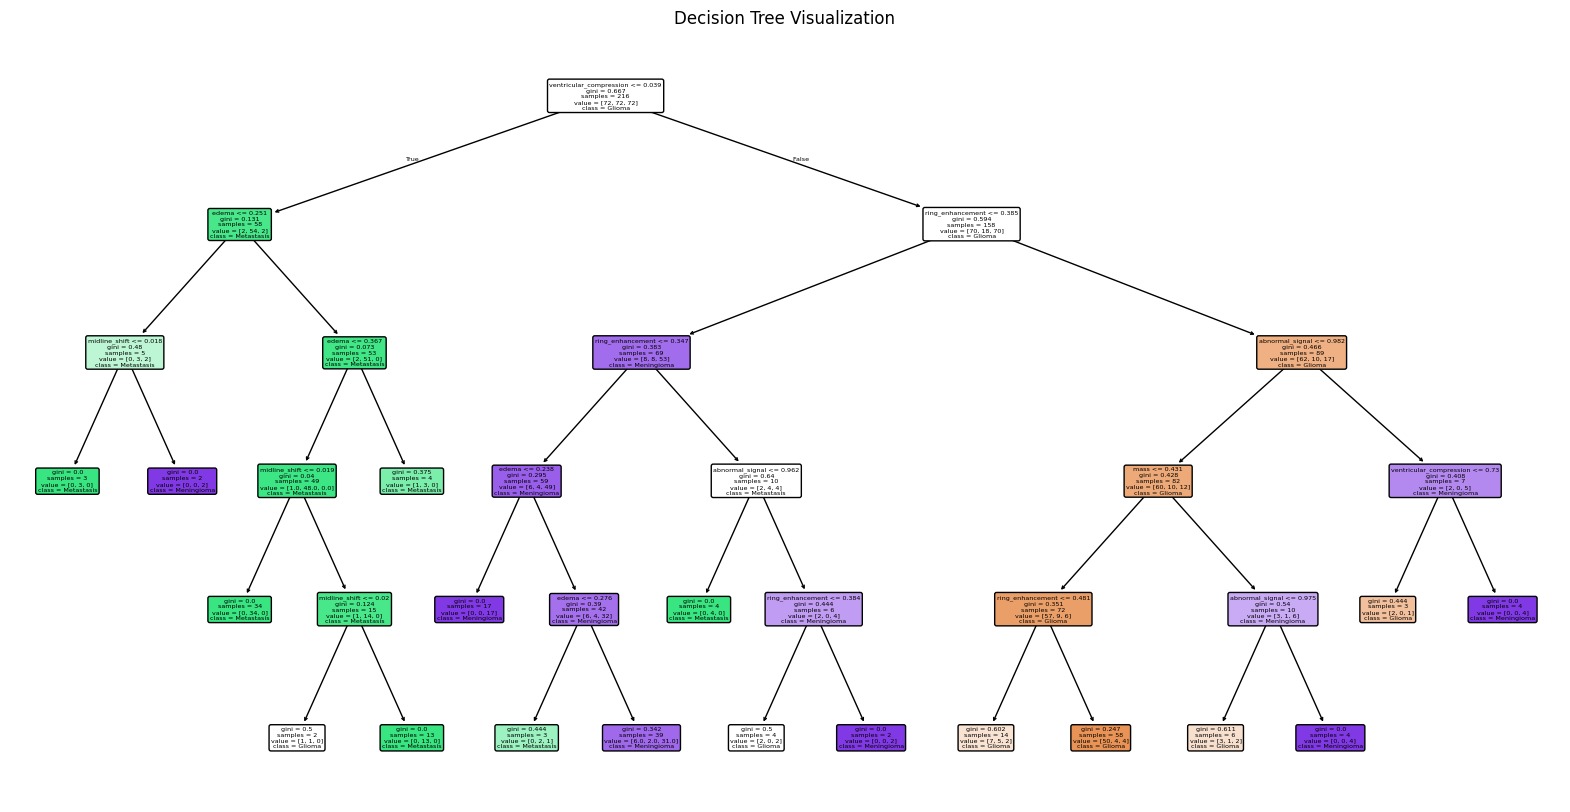

In [ ]:
def get_concept_predictions(X_views, models):
    """
    Get concept predictions from all views and combine them using ensemble model
    """
    X_axial, X_coronal, X_sagittal = X_views
    axial_model, coronal_model, sagittal_model, ensemble_model = models

    # Get individual view predictions
    print("Getting predictions from individual models...")
    axial_preds = axial_model.predict(X_axial, batch_size=32, verbose=1)
    coronal_preds = coronal_model.predict(X_coronal, batch_size=32, verbose=1)
    sagittal_preds = sagittal_model.predict(X_sagittal, batch_size=32, verbose=1)

    print("\nPrediction shapes:")
    print(f"Axial predictions: {axial_preds.shape}")
    print(f"Coronal predictions: {coronal_preds.shape}")
    print(f"Sagittal predictions: {sagittal_preds.shape}")

    # Check ensemble model input shape
    print("\nEnsemble model input shapes:")
    for i, input_layer in enumerate(ensemble_model.inputs):
        print(f"Input {i} expected shape: {input_layer.shape}")

    # Ensure predictions match expected shape
    if axial_preds.shape[1] != len(CONCEPTS):
        print(f"Warning: Axial predictions shape mismatch. Expected {len(CONCEPTS)} concepts, got {axial_preds.shape[1]}")
        # Trim or pad predictions if necessary
        axial_preds = axial_preds[:, :len(CONCEPTS)]

    if coronal_preds.shape[1] != len(CONCEPTS):
        print(f"Warning: Coronal predictions shape mismatch. Expected {len(CONCEPTS)} concepts, got {coronal_preds.shape[1]}")
        coronal_preds = coronal_preds[:, :len(CONCEPTS)]

    if sagittal_preds.shape[1] != len(CONCEPTS):
        print(f"Warning: Sagittal predictions shape mismatch. Expected {len(CONCEPTS)} concepts, got {sagittal_preds.shape[1]}")
        sagittal_preds = sagittal_preds[:, :len(CONCEPTS)]

    # Combine using ensemble model
    print("\nGenerating ensemble predictions...")
    ensemble_preds = ensemble_model.predict(
        [axial_preds, coronal_preds, sagittal_preds],
        batch_size=32,
        verbose=1
    )

    print(f"\nFinal ensemble predictions shape: {ensemble_preds.shape}")

    return ensemble_preds

# Rest of the code remains the same
synthetic_dirs = {
    'axial': data_dir_axial_syn,
    'coronal': data_dir_coronal_syn,
    'sagittal': data_dir_sagittal_syn
}

# Load synthetic images
X_views, y = load_synthetic_images(synthetic_dirs, samples_per_class=90)

# Get concept predictions using our trained models
models = (axial_model, coronal_model, sagittal_model, ensemble_model)
X_concepts = get_concept_predictions(X_views, models)

print("\nDataset summary:")
print(f"Total samples: {len(X_concepts)}")
print(f"Feature names: {CONCEPTS}")
print(f"Class distribution: {np.bincount(y)}")

# Train and evaluate decision tree using concept predictions
dt_model = train_evaluate_tree(X_concepts, y, CONCEPTS)

In [ ]:


data_dir_axial_syn = {
    'GLI': '/content/drive/MyDrive/npzs-all-planes-synthetic/Axial/GLI_axial_synthetic',
    'MET': '/content/drive/MyDrive/npzs-all-planes-synthetic/Axial/MET_axial_synthetic',
    'MEN': '/content/drive/MyDrive/npzs-all-planes-synthetic/Axial/MEN_axial_synthetic'
}

data_dir_coronal_syn = {
    'GLI': '/content/drive/MyDrive/npzs-all-planes-synthetic/Coronal/GLI_coronal_synthetic',
    'MET': '/content/drive/MyDrive/npzs-all-planes-synthetic/Coronal/MET_coronal_synthetic',
    'MEN': '/content/drive/MyDrive/npzs-all-planes-synthetic/Coronal/MEN_coronal_synthetic'
}

data_dir_sagittal_syn = {
    'GLI': '/content/drive/MyDrive/npzs-all-planes-synthetic/Sagittal/GLI_sagittal_synthetic',
    'MET': '/content/drive/MyDrive/npzs-all-planes-synthetic/Sagittal/MET_sagittal_synthetic',
    'MEN': '/content/drive/MyDrive/npzs-all-planes-synthetic/Sagittal/MEN_sagittal_synthetic'
}


In [ ]:
def load_synthetic_data_from_directory(directory, expected_shape, n_samples=90):
    """
    Load synthetic data from directory with shape validation
    """
    X_data = []
    count = 0

    for file_name in sorted(os.listdir(directory)):
        if count >= n_samples:
            break
        if file_name.endswith('.npz'):
            try:
                file_path = os.path.join(directory, file_name)
                data = np.load(file_path, allow_pickle=True)
                image = data['image']

                # Check and validate image shape
                if image.shape != expected_shape:
                    print(f"Skipping {file_name} - Expected shape {expected_shape}, got {image.shape}")
                    continue

                # Ensure image is float32 and normalized
                image = image.astype('float32')
                if image.max() > 1.0:
                    image = image / 255.0

                X_data.append(image)
                count += 1
            except Exception as e:
                print(f"Error loading {file_name}: {str(e)}")
                continue

    if not X_data:
        raise ValueError(f"No valid images found in {directory}")

    return np.array(X_data)

def evaluate_concept_prediction_pipeline(data_dir_axial_syn, data_dir_coronal_syn, data_dir_sagittal_syn,
                                      axial_model, coronal_model, sagittal_model,
                                      ensemble_model, dt_model, n_samples=90, threshold=0.6, binary_classification=True):
    """
    Evaluates the full concept prediction pipeline on synthetic data
    binary_classification: If True, only include GLI and MET classes (no MEN)
    """
    # Define expected shapes
    axial_shape = (240, 240, 3)
    coronal_shape = (240, 155, 3)
    sagittal_shape = (240, 155, 3)

    # Lists to store true labels
    true_labels = []

    # Load synthetic data for each tumor type
    X_axial, X_coronal, X_sagittal = [], [], []

    # Define which tumor types to process
    tumor_types = ['GLI', 'MET'] if binary_classification else ['GLI', 'MET', 'MEN']

    for tumor_type in tumor_types:
        print(f"\nProcessing {tumor_type} data...")
        try:
            # Load data for each plane
            axial_data = load_synthetic_data_from_directory(
                data_dir_axial_syn[tumor_type], axial_shape, n_samples)
            print(f"Loaded {len(axial_data)} axial images")

            coronal_data = load_synthetic_data_from_directory(
                data_dir_coronal_syn[tumor_type], coronal_shape, n_samples)
            print(f"Loaded {len(coronal_data)} coronal images")

            sagittal_data = load_synthetic_data_from_directory(
                data_dir_sagittal_syn[tumor_type], sagittal_shape, n_samples)
            print(f"Loaded {len(sagittal_data)} sagittal images")

            # Append data
            X_axial.append(axial_data)
            X_coronal.append(coronal_data)
            X_sagittal.append(sagittal_data)

            # Add labels (0 for GLI, 1 for MET)
            true_labels.extend([0 if tumor_type == 'GLI' else 1] * len(axial_data))

        except Exception as e:
            print(f"Error processing {tumor_type}: {str(e)}")
            continue

    if not (X_axial and X_coronal and X_sagittal):
        raise ValueError("No valid data loaded for one or more planes")

    # Concatenate data from all tumor types
    X_axial = np.concatenate(X_axial)
    X_coronal = np.concatenate(X_coronal)
    X_sagittal = np.concatenate(X_sagittal)
    true_labels = np.array(true_labels)

    print("\nData loaded:")
    print(f"Axial shape: {X_axial.shape}")
    print(f"Coronal shape: {X_coronal.shape}")
    print(f"Sagittal shape: {X_sagittal.shape}")
    print(f"Number of samples: {len(true_labels)}")

    # Step 1: Predict concepts using individual models
    print("\nGenerating concept predictions...")
    axial_concepts = axial_model.predict(X_axial)
    coronal_concepts = coronal_model.predict(X_coronal)
    sagittal_concepts = sagittal_model.predict(X_sagittal)

    print("Concept predictions shapes:")
    print(f"Axial concepts: {axial_concepts.shape}")
    print(f"Coronal concepts: {coronal_concepts.shape}")
    print(f"Sagittal concepts: {sagittal_concepts.shape}")

    # Step 2: Use ensemble model to combine concept predictions
    print("\nGenerating ensemble predictions...")
    ensemble_inputs = [axial_concepts, coronal_concepts, sagittal_concepts]
    ensemble_concepts = ensemble_model.predict(ensemble_inputs)
    print(f"Ensemble concepts shape: {ensemble_concepts.shape}")

    # Step 3: Use decision tree to predict tumor type using binary concepts
    print("\nGenerating final predictions...")
    final_predictions = dt_model.predict(ensemble_concepts)

    # Evaluate results
    accuracy = accuracy_score(true_labels, final_predictions)
    print("\nPipeline Evaluation Results:")
    print("-" * 50)
    print(f"Overall Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")

    # Use appropriate target names based on binary classification
    target_names = ['Glioma', 'Metastasis'] if binary_classification else ['Glioma', 'Metastasis', 'Meningioma']
    print(classification_report(true_labels, final_predictions, target_names=target_names))

    print("\nConfusion Matrix:")
    print(confusion_matrix(true_labels, final_predictions))

    return accuracy, final_predictions, true_labels


In [ ]:
final_results = evaluate_concept_prediction_pipeline(data_dir_axial_syn, data_dir_coronal_syn, data_dir_sagittal_syn,
                                      axial_model, coronal_model, sagittal_model,
                                      ensemble_model, dt_binary, n_samples=75,
                                                     threshold=0.5)


Processing GLI data...
Loaded 75 axial images
Loaded 75 coronal images
Loaded 75 sagittal images

Processing MET data...
Skipping BraTS-MET-00595-000_axial_largest_slice.npz - Expected shape (240, 240, 3), got (400, 90, 3)
Skipping BraTS-MET-00694-000_axial_largest_slice.npz - Expected shape (240, 240, 3), got (288, 90, 3)
Loaded 75 axial images
Loaded 75 coronal images
Skipping BraTS-MET-00595-000_sagittal_largest_slice.npz - Expected shape (240, 155, 3), got (90, 400, 3)
Skipping BraTS-MET-00694-000_sagittal_largest_slice.npz - Expected shape (240, 155, 3), got (90, 288, 3)
Loaded 75 sagittal images

Data loaded:
Axial shape: (150, 240, 240, 3)
Coronal shape: (150, 240, 155, 3)
Sagittal shape: (150, 240, 155, 3)
Number of samples: 150

Generating concept predictions...
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 983ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 447ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step
Concept predictions shapes:
Axial concepts: (150, 7)
Coronal concepts: (150, 7)
Sagittal concepts: (

- data aug vs no data aug
- inception vs vg16
- img vs npz
- concept weighting vs none
- different test/train split

no data gen axial: 0.29 valid acc, 71 acc